In [1]:
import pandas as pd
import numpy as np
import ast
import pickle
from pathlib import Path
import matplotlib.pyplot as plt
import spikeanal as spike
from matplotlib_venn import venn2
from matplotlib_venn import venn3

cols = ['condition ', 'session_dir', 'all_subjects', 'tone_start_timestamp', 'tone_stop_timestamp']

# Load the data
df = pd.read_excel('rce_pilot_2_per_video_trial_labels.xlsx', usecols=cols, engine='openpyxl')

df2 = df.dropna() # Drop the rows missing data
df3 = df2.copy()
df3['all_subjects'] = df3['all_subjects'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x) # Make the 'all_subjects' column readable as a list
df4 = df3[df3['all_subjects'].apply(lambda x: len(x) < 3)] # Ignore novel sessions for now

# Initialize an empty list to collect data for the new DataFrame
new_df_data = []

for _, row in df4.iterrows():
    session_dir = row['session_dir']
    subjects = row['all_subjects']
    condition = row['condition ']

    # Split session_dir on '_subj_' and take the first part only
    # This ensures everything after '_subj_' is ignored
    base_session_dir = session_dir.split('_subj_')[0]

    for subject in subjects:
        subject_formatted = subject.replace('.', '-')
        # Append formatted subject to the base session_dir correctly
        subj_recording = f"{base_session_dir}_subj_{subject_formatted}"
        new_df_data.append({
            'session_dir': session_dir,
            'subject': subject,
            'subj_recording': subj_recording,
            'condition': condition if condition in ['rewarded', 'omission', 'both_rewarded', 'tie'] else ('win' if str(condition) == str(subject) else 'lose'),
            'tone_start_timestamp': row['tone_start_timestamp'],
            'tone_stop_timestamp': row['tone_stop_timestamp']
        })

# Convert list to DataFrame
new_df = pd.DataFrame(new_df_data)
new_df = new_df.drop_duplicates()

# Prepare timestamp_dicts from new_df
timestamp_dicts = {}
for _, row in new_df.iterrows():
    key = row['subj_recording']
    condition = row['condition']
    timestamp_start = int(row['tone_start_timestamp']) // 20
    timestamp_end = int(row['tone_stop_timestamp']) // 20
    tuple_val = (timestamp_start, timestamp_end)

    if key not in timestamp_dicts:
        timestamp_dicts[key] = {cond: [] for cond in ['rewarded', 'win', 'lose', 'omission', 'both_rewarded', 'tie']}
    timestamp_dicts[key][condition].append(tuple_val)

# Convert lists in timestamp_dicts to numpy arrays
for subj_recording in timestamp_dicts:
    for condition in timestamp_dicts[subj_recording]:
        timestamp_dicts[subj_recording][condition] = np.array(timestamp_dicts[subj_recording][condition], dtype=np.int64)
        

# Construct the path in a platform-independent way (HiPerGator or Windows)
ephys_path = Path('.') / 'export' / 'updated_phys' / 'non-novel' / 'both_rewarded'

ephys_data = spike.EphysRecordingCollection(str(ephys_path))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
Unit 92 is unsorted & has 2494 spikes
Unit 92 will be deleted
20230622_110832_standard_comp_to_both_rewarded_D1_subj_1-1_t1b3L_box1_merged.rec
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
Unit 103 is unsorted & has 512 spikes
Unit 103 will be deleted
20230622_110832_standard_comp_to_both_rewarded_D1_subj_1-2_t3b3L_box1_merged.rec
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
20230624_105855_standard_comp_to_both_rewarded_D3_subj_1-2_t1b2L_box1_merged.rec
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
20230624_105855_standard_comp_to_both_rewarded_D3_subj_1-4_t3b3L_box1_merged.rec
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
20230625_112913_standard_comp_to_both_rewarded_D4_subj_1-1_t1b2L_box1_merged.rec
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
Unit 96 is unsorted & has 5811 spikes
Unit 96 will be deleted
Unit 95 is unsorted & has 6458 spikes
Unit 95 will be deleted
20230625_112913_standard_comp_to_both_rewarded_D4_subj_1-4

In [2]:
for recording in ephys_data.collection.keys():
    # Check if the recording key (without everything after subject #) is in timestamp_dicts
    start_pos = recording.find('subj_')
    # Add the length of 'subj_' and 3 additional characters to include after 'subj_'
    end_pos = start_pos + len('subj_') + 3
    # Slice the recording key to get everything up to and including the subject identifier plus three characters
    recording_key_without_suffix = recording[:end_pos]
    if recording_key_without_suffix in timestamp_dicts:
        # Assign the corresponding timestamp_dicts dictionary to event_dict
        ephys_data.collection[recording].event_dict = timestamp_dicts[recording_key_without_suffix]
        
        # Extract the subject from the recording key
        start = recording.find('subj_') + 5  # Start index after 'subj_'
        subject = recording[start:start+3]
        
        # Assign the extracted subject
        ephys_data.collection[recording].subject = subject
        
spike_analysis = spike.SpikeAnalysis_MultiRecording(ephys_data, timebin = 100, smoothing_window=250, ignore_freq = 0.5)

All set to analyze


In [3]:
first5_win_df = spike_analysis.wilcox_baseline_v_event_collection(event='win', equalize=5, baseline_window=10, offset=0,  plot=False)
first5_lose_df = spike_analysis.wilcox_baseline_v_event_collection(event='lose', equalize=5, baseline_window=10, offset=0,  plot=False)
first5_both_rewarded_df = spike_analysis.wilcox_baseline_v_event_collection(event='both_rewarded', equalize=5, baseline_window=10, offset=0,  plot=False)

last5_win_df = spike_analysis.wilcox_baseline_v_event_collection(event='win', equalize=5, baseline_window=10, offset=-5,  plot=False)
last5_lose_df = spike_analysis.wilcox_baseline_v_event_collection(event='lose', equalize=5, baseline_window=10, offset=-5,  plot=False)
last5_both_rewarded_df = spike_analysis.wilcox_baseline_v_event_collection(event='both_rewarded', equalize=5, baseline_window=10, offset=-5,  plot=False)

C:\Users\short\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:4102: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
C:\Users\short\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:4102: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
C:\Users\short\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:4102: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
C:\Users\short\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:4102: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


In [4]:
def aggregate_event_data(df_list, time_segment):
    # Step 1: Concatenate the DataFrames
    combined_df = pd.concat(df_list)

    # Function to extract just the event name
    def extract_event_name(event):
        # Remove any leading time duration from the event string
        parts = event.split(' vs ')
        event_name = parts[0].split(' ')[-1]  # Splits by space and takes the last part, removing any time prefix
        return event_name

    # Initialize an empty dictionary to hold aggregated data
    aggregated_data = {}

    # Iterate over the rows of the combined DataFrame
    for index, row in combined_df.iterrows():
        # Extract event name
        event_name = extract_event_name(row['Event'])
        # Construct a unique key for each combination of recording, subject, and unit id
        key = (row['Recording'], row['Subject'], row['original unit id'])
        
        # Initialize the entry if not exists
        if key not in aggregated_data:
            aggregated_data[key] = {'sig_increase_events': set(), 'sig_decrease_events': set(), 'insig_events': set()}
        
        # Append the event name to the appropriate category based on 'event1 vs event2'
        if row['event1 vs event2'] == 'increases':
            aggregated_data[key]['sig_increase_events'].add(event_name)
        elif row['event1 vs event2'] == 'decreases':
            aggregated_data[key]['sig_decrease_events'].add(event_name)
        else:
            aggregated_data[key]['insig_events'].add(event_name)

    # Convert the aggregated data into a DataFrame
    rows = []
    for (recording, subject, unit_id), categories in aggregated_data.items():
        row = {
            'Recording': recording,
            'Subject': subject,
            'original unit id': unit_id,
            'sig_increase_events': ', '.join(categories['sig_increase_events']),
            'sig_decrease_events': ', '.join(categories['sig_decrease_events']),
            'insig_events': ', '.join(categories['insig_events']),
        }
        rows.append(row)

    aggregated_df = pd.DataFrame(rows)
    aggregated_df['sig_events'] = aggregated_df.apply(
        lambda row: ', '.join(filter(None, [row['sig_increase_events'], row['sig_decrease_events']])), axis=1)

    # Function to normalize event strings
    def normalize_event_string(event_string):
        event_list = event_string.split(', ')
        event_list_sorted = sorted(event_list)  # Sort the list to ensure consistent order
        return ', '.join(event_list_sorted)  # Join the sorted list back into a string

    # Apply the normalization function to the 'sig_events' column before counting
    aggregated_df['sig_events'] = aggregated_df['sig_events'].apply(normalize_event_string)

    # Count the unique combinations of significant events
    sig_events_counts = aggregated_df['sig_events'].value_counts()

    # Rename the empty strings to 'non-specific'
    sig_events_counts = sig_events_counts.rename(index={'': 'Non-Responsive'})

    return aggregated_df, sig_events_counts

# Usage
first5_dfs = [first5_win_df, first5_lose_df, first5_both_rewarded_df]
last5_dfs = [last5_win_df, last5_lose_df, last5_both_rewarded_df]

first5_aggregated_df, first5_sig_events_counts = aggregate_event_data(first5_dfs, 'first 5 seconds')
last5_aggregated_df, last5_sig_events_counts = aggregate_event_data(last5_dfs, 'last 5 seconds')

In [5]:
# Add prefixes to distinguish between first 5 and last 5 seconds
first5_aggregated_df = first5_aggregated_df.add_prefix('first5_')
last5_aggregated_df = last5_aggregated_df.add_prefix('last5_')

# Rename the keys for merging to be the same
first5_aggregated_df.rename(columns={
    'first5_Recording': 'Recording',
    'first5_Subject': 'Subject',
    'first5_original unit id': 'original unit id'
}, inplace=True)

last5_aggregated_df.rename(columns={
    'last5_Recording': 'Recording',
    'last5_Subject': 'Subject',
    'last5_original unit id': 'original unit id'
}, inplace=True)

# Merge the dataframes on Recording, Subject, and original unit id
merged_df = pd.merge(
    first5_aggregated_df,
    last5_aggregated_df,
    on=['Recording', 'Subject', 'original unit id'],
    how='outer'  # You can choose 'inner' if you only want units present in both or 'outer' to keep all units
)

# Show the result to confirm it merged as expected
merged_df

,Recording,Subject,original unit id,first5_sig_increase_events,first5_sig_decrease_events,first5_insig_events,first5_sig_events,last5_sig_increase_events,last5_sig_decrease_events,last5_insig_events,last5_sig_events
0,20230622_110832_standard_comp_to_both_rewarded...,1-1,9,,,"both_rewarded, win, lose",,,,"both_rewarded, win, lose",
1,20230622_110832_standard_comp_to_both_rewarded...,1-1,24,,,"both_rewarded, win, lose",,,,"both_rewarded, win, lose",
2,20230622_110832_standard_comp_to_both_rewarded...,1-1,76,,,"both_rewarded, win, lose",,,,"both_rewarded, win, lose",
3,20230622_110832_standard_comp_to_both_rewarded...,1-1,10,both_rewarded,,"win, lose",both_rewarded,both_rewarded,,"win, lose",both_rewarded
4,20230622_110832_standard_comp_to_both_rewarded...,1-1,94,both_rewarded,,"win, lose",both_rewarded,,,"both_rewarded, win, lose",
...,...,...,...,...,...,...,...,...,...,...,...
116,20230625_112913_standard_comp_to_both_rewarded...,1-4,39,,both_rewarded,"win, lose",both_rewarded,both_rewarded,,"win, lose",both_rewarded
117,20230625_112913_standard_comp_to_both_rewarded...,1-4,17,both_rewarded,,"win, lose",both_rewarded,both_rewarded,,"win, lose",both_rewarded
118,20230625_112913_standard_comp_to_both_rewarded...,1-4,15,,,"both_rewarded, win, lose",,,,"both_rewarded, win, lose",
119,20230625_112913_standard_comp_to_both_rewarded...,1-4,27,both_rewarded,,"win, lose",both_rewarded,both_rewarded,,"win, lose",both_rewarded


In [6]:
# Function to convert event strings to sets
def convert_to_set(event_string):
    return set(event_string.split(', ')) if event_string else set()

merged_df1 = merged_df.copy()

# Apply conversion to DataFrame
merged_df1['first5_set'] = merged_df['first5_sig_events'].apply(convert_to_set)
merged_df1['last5_set'] = merged_df['last5_sig_events'].apply(convert_to_set)

# Define the logic for determining the result
def determine_result(row):
    first_set = row['first5_set']
    last_set = row['last5_set']
    if not first_set and not last_set:
        return 'non-responsive'
    if first_set == last_set:
        if len(first_set) > 1:
            return 'multi-event_same'
        return ', '.join(first_set)
    if first_set.isdisjoint(last_set):
        return 'multi-event_different' if first_set and last_set else ('first5_' + ', '.join(first_set) if first_set else 'last5_' + ', '.join(last_set))
    return 'single-event_different'

# Apply the determination function to each row
merged_df1['Result'] = merged_df1.apply(determine_result, axis=1)

## Create a df of each scenario and test the function to determine the result

In [7]:
from itertools import combinations, chain

def generate_combinations(events):
    # Generate all combinations of the events list
    comb = (combinations(events, r) for r in range(len(events) + 1))
    # Flatten the list of combinations and convert each to a sorted tuple
    flat_comb = ['; '.join(sorted(c)) for sublist in comb for c in sublist if c]
    return [''] + flat_comb  # Include the empty set

# Define the possible events
events = ['lose', 'both_rewarded', 'win']

# Generate combinations for first5 and last5
first5_combinations = generate_combinations(events)
last5_combinations = generate_combinations(events)

# Create a DataFrame from all pairs of combinations
data = [(f5, l5) for f5 in first5_combinations for l5 in last5_combinations]
combinations_df = pd.DataFrame(data, columns=['first5_sig_events', 'last5_sig_events'])

combinations_df

,first5_sig_events,last5_sig_events
0,,
1,,lose
2,,both_rewarded
3,,win
4,,both_rewarded; lose
...,...,...
59,both_rewarded; lose; win,win
60,both_rewarded; lose; win,both_rewarded; lose
61,both_rewarded; lose; win,lose; win
62,both_rewarded; lose; win,both_rewarded; win


In [8]:
def determine_result(row):
    first_set = row['first5_set']
    last_set = row['last5_set']

    # Cases where both sets are empty
    if not first_set and not last_set:
        return 'non-responsive'
    
    # Cases where only one set is non-empty
    if not first_set:
        if len(last_set) == 1:
            return 'last5_' + ', '.join(last_set)
        return 'last5_multi_event'
    if not last_set:
        if len(first_set) == 1:
            return 'first5_' + ', '.join(first_set)
        return 'first5_multi_event'

    # Cases where both sets are non-empty
    if len(first_set) == 1 and len(last_set) == 1:
        if first_set == last_set:
            return ', '.join(first_set)  # Single matching event in both
        return 'single-event_different'

    if len(first_set) > 1 and len(last_set) > 1:
        if first_set == last_set:
            return 'multi_event_same'
        return 'multi_event_different'

    # All other cases where one set has more than one event and the other has one or more
    return 'multi_event_different'

combinations_df6 = combinations_df.copy()

combinations_df6['first5_set'] = combinations_df6['first5_sig_events'].apply(convert_to_set)
combinations_df6['last5_set'] = combinations_df6['last5_sig_events'].apply(convert_to_set)

# Apply the function to the DataFrame
combinations_df6['Result'] = combinations_df6.apply(determine_result, axis=1)

# Check the counts of each result category
combinations_df6['Result'].value_counts()

Result
single-event_different             42
non-responsive                      1
both_rewarded                       1
first5_both_rewarded; lose; win     1
both_rewarded; win                  1
first5_both_rewarded; win           1
lose; win                           1
first5_lose; win                    1
both_rewarded; lose                 1
first5_both_rewarded; lose          1
win                                 1
first5_win                          1
first5_both_rewarded                1
last5_lose                          1
lose                                1
first5_lose                         1
last5_both_rewarded; lose; win      1
last5_both_rewarded; win            1
last5_lose; win                     1
last5_both_rewarded; lose           1
last5_win                           1
last5_both_rewarded                 1
both_rewarded; lose; win            1
Name: count, dtype: int64

### ^ That's what it should be. So it works!

In [9]:
# Function to convert event strings to sets
def convert_to_set(event_string):
    return set(event_string.split(', ')) if event_string else set()

merged_df2 = merged_df.copy()

# Apply conversion to DataFrame
merged_df2['first5_set'] = merged_df2['first5_sig_events'].apply(convert_to_set)
merged_df2['last5_set'] = merged_df2['last5_sig_events'].apply(convert_to_set)

# Apply the determination function to each row
merged_df2['Result'] = merged_df2.apply(determine_result, axis=1)
both_rewarded_first5_last5_counts = merged_df2['Result'].value_counts()

both_rewarded_first5_last5_counts

Result
non-responsive           39
both_rewarded            36
multi_event_same         12
win                      11
first5_both_rewarded      6
multi_event_different     6
last5_both_rewarded       6
first5_win                2
last5_win                 1
lose                      1
last5_lose                1
Name: count, dtype: int64

In [10]:
def determine_result(row):
    first_set = row['first5_set']
    last_set = row['last5_set']

    # Cases where both sets are empty
    if not first_set and not last_set:
        return 'Non-Responsive'
    
    # Cases where only one set is non-empty
    if not first_set:
        if len(last_set) == 1:
            return 'Dispense Single'
        return 'Dispense Multi'
    if not last_set:
        if len(first_set) == 1:
            return 'Alert Single'
        return 'Alert Multi'

    # Cases where both sets are non-empty
    if len(first_set) == 1 and len(last_set) == 1:
        if first_set == last_set:
            return 'Single Same'
        return 'Single Different'

    if len(first_set) > 1 and len(last_set) > 1:
        if first_set == last_set:
            return 'Multi Same'
        return 'Multi Different'

    # All other cases where one set has more than one event and the other has one or more
    return 'Multi Different'

def convert_to_set(event_string):
    return set(event_string.split('; ')) if event_string else set()

combinations_df6 = combinations_df.copy()

combinations_df6['first5_set'] = combinations_df6['first5_sig_events'].apply(convert_to_set)
combinations_df6['last5_set'] = combinations_df6['last5_sig_events'].apply(convert_to_set)

# Apply the function to the DataFrame
combinations_df6['Result'] = combinations_df6.apply(determine_result, axis=1)

# Check the counts of each result category
combinations_df6['Result'].value_counts()

Result
Multi Different     36
Single Different     6
Dispense Multi       4
Alert Multi          4
Multi Same           4
Dispense Single      3
Alert Single         3
Single Same          3
Non-Responsive       1
Name: count, dtype: int64

In [11]:
def determine_result(row):
    first_set = row['first5_set']
    last_set = row['last5_set']

    # Cases where both sets are empty
    if not first_set and not last_set:
        return 'Non-Responsive'
    
    # Cases where only one set is non-empty
    if not first_set:
        if len(last_set) == 1:
            return 'Dispense Single'
        return 'Dispense Multi'
    if not last_set:
        if len(first_set) == 1:
            return 'Alert Single'
        return 'Alert Multi'

    # Cases where both sets are non-empty
    if len(first_set) == 1 and len(last_set) == 1:
        if first_set == last_set:
            return 'Single Same'
        return 'Single Different'

    if len(first_set) > 1 and len(last_set) > 1:
        if first_set == last_set:
            return 'Multi Same'
        return 'Multi Different'

    # All other cases where one set has more than one event and the other has one or more
    return 'Multi Different'

def convert_to_set(event_string):
    return set(event_string.split(', ')) if event_string else set()

merged_df1 = merged_df.copy()

merged_df1['first5_set'] = merged_df1['first5_sig_events'].apply(convert_to_set)
merged_df1['last5_set'] = merged_df1['last5_sig_events'].apply(convert_to_set)

# Apply the function to the DataFrame
merged_df1['Result'] = merged_df1.apply(determine_result, axis=1)

# Check the counts of each result category
merged_df1['Result'].value_counts()

Result
Single Same        48
Non-Responsive     39
Multi Same         12
Alert Single        8
Dispense Single     8
Multi Different     6
Name: count, dtype: int64

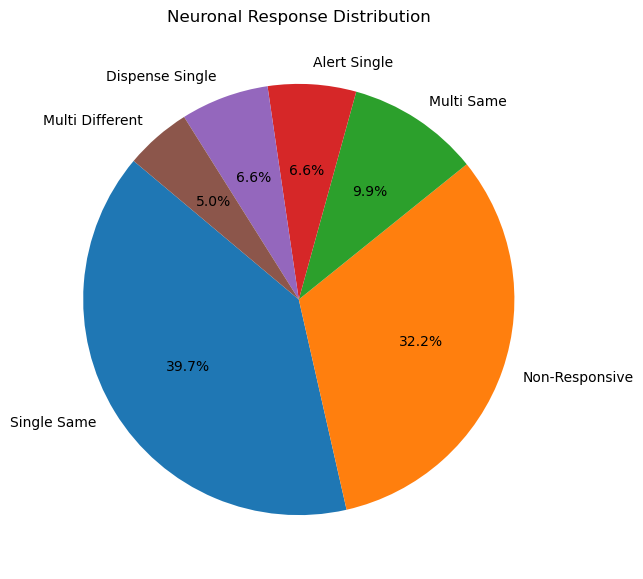

In [12]:
import matplotlib.pyplot as plt

# This assumes merged_df1 is already defined and has a 'Result' column properly set up
result_counts = merged_df1['Result'].value_counts()

# Create the pie plot
plt.figure(figsize=(10, 7))
plt.pie(result_counts, labels=result_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Neuronal Response Distribution')

# Display the plot
plt.show()
# Optionally save the plot
# plt.savefig('Neuronal_Response_Distribution.png', bbox_inches='tight')

In [13]:
def determine_result(row):
    first_set = row['first5_set']
    last_set = row['last5_set']

    # Cases where both sets are empty
    if not first_set and not last_set:
        return 'Non-Responsive'
    
    # Cases where only one set is non-empty
    if not first_set:
        return 'Dispense Only'
    if not last_set:
        return 'Alert Only'

    if first_set == last_set:
        return 'Alert & Dispense - Same'
        
    # All other cases where one set has more than one event and the other has one or more
    return 'Alert & Dispesne - Different'

def convert_to_set(event_string):
    return set(event_string.split(', ')) if event_string else set()

merged_df1 = merged_df.copy()

merged_df1['first5_set'] = merged_df1['first5_sig_events'].apply(convert_to_set)
merged_df1['last5_set'] = merged_df1['last5_sig_events'].apply(convert_to_set)

# Apply the function to the DataFrame
merged_df1['Result'] = merged_df1.apply(determine_result, axis=1)

# Check the counts of each result category
merged_df1['Result'].value_counts()

Result
Alert & Dispense - Same         60
Non-Responsive                  39
Alert Only                       8
Dispense Only                    8
Alert & Dispesne - Different     6
Name: count, dtype: int64

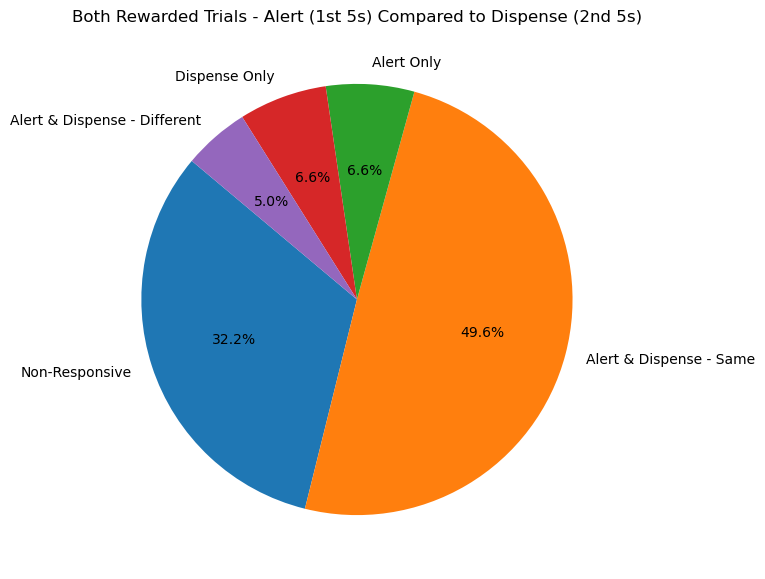

In [14]:
Pieplot_labels = ('Non-Responsive', 'Alert & Dispense - Same', 'Alert Only', 'Dispense Only', 'Alert & Dispense - Different')
Pieplot_data = (39, 60, 8, 8, 6)

# Create the pie plot
plt.figure(figsize=(10, 7))
plt.pie(Pieplot_data, labels=Pieplot_labels, autopct='%1.1f%%', startangle=140)
plt.title('Both Rewarded Trials - Alert (1st 5s) Compared to Dispense (2nd 5s)')

# Display the plot
# plt.show()
plt.savefig('both_reward_alert_dispense.png', bbox_inches='tight')

In [15]:
import pandas as pd
import numpy as np
import ast
import pickle
from pathlib import Path
import matplotlib.pyplot as plt
import spikeanal as spike
from matplotlib_venn import venn2
from matplotlib_venn import venn3

cols = ['condition ', 'session_dir', 'all_subjects', 'tone_start_timestamp', 'tone_stop_timestamp']

# Load the data
df = pd.read_excel('rce_pilot_2_per_video_trial_labels.xlsx', usecols=cols, engine='openpyxl')

df2 = df.dropna() # Drop the rows missing data
df3 = df2.copy()
df3['all_subjects'] = df3['all_subjects'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x) # Make the 'all_subjects' column readable as a list
df4 = df3[df3['all_subjects'].apply(lambda x: len(x) < 3)] # Ignore novel sessions for now

# Initialize an empty list to collect data for the new DataFrame
new_df_data = []

for _, row in df4.iterrows():
    session_dir = row['session_dir']
    subjects = row['all_subjects']
    condition = row['condition ']

    # Split session_dir on '_subj_' and take the first part only
    # This ensures everything after '_subj_' is ignored
    base_session_dir = session_dir.split('_subj_')[0]

    for subject in subjects:
        subject_formatted = subject.replace('.', '-')
        # Append formatted subject to the base session_dir correctly
        subj_recording = f"{base_session_dir}_subj_{subject_formatted}"
        new_df_data.append({
            'session_dir': session_dir,
            'subject': subject,
            'subj_recording': subj_recording,
            'condition': condition if condition in ['rewarded', 'omission', 'both_rewarded', 'tie'] else ('win' if str(condition) == str(subject) else 'lose'),
            'tone_start_timestamp': row['tone_start_timestamp'],
            'tone_stop_timestamp': row['tone_stop_timestamp']
        })

# Convert list to DataFrame
new_df = pd.DataFrame(new_df_data)
new_df = new_df.drop_duplicates()

# Prepare timestamp_dicts from new_df
timestamp_dicts = {}
for _, row in new_df.iterrows():
    key = row['subj_recording']
    condition = row['condition']
    timestamp_start = int(row['tone_start_timestamp']) // 20
    timestamp_end = int(row['tone_stop_timestamp']) // 20
    tuple_val = (timestamp_start, timestamp_end)

    if key not in timestamp_dicts:
        timestamp_dicts[key] = {cond: [] for cond in ['rewarded', 'win', 'lose', 'omission', 'both_rewarded', 'tie']}
    timestamp_dicts[key][condition].append(tuple_val)

# Convert lists in timestamp_dicts to numpy arrays
for subj_recording in timestamp_dicts:
    for condition in timestamp_dicts[subj_recording]:
        timestamp_dicts[subj_recording][condition] = np.array(timestamp_dicts[subj_recording][condition], dtype=np.int64)
        

# Construct the path in a platform-independent way (HiPerGator or Windows)
ephys_path = Path('.') / 'export' / 'updated_phys' / 'non-novel' / 'omission'

omis_ephys_data = spike.EphysRecordingCollection(str(ephys_path))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged.rec
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
20230617_115521_standard_comp_to_omission_D1_subj_1-2_t2b2L_box2_merged.rec
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
20230618_100636_standard_comp_to_omission_D2_subj_1-1_t1b2L_box2_merged.rec
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
20230618_100636_standard_comp_to_omission_D2_subj_1-4_t4b3L_box1_merged.rec
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged.rec
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged.rec
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged.rec
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
20230621_111240_standard_comp_to_omission_D5_subj_1-4_t3b3L_box1_merged.rec
Please

In [16]:
for recording in omis_ephys_data.collection.keys():
    # Check if the recording key (without everything after subject #) is in timestamp_dicts
    start_pos = recording.find('subj_')
    # Add the length of 'subj_' and 3 additional characters to include after 'subj_'
    end_pos = start_pos + len('subj_') + 3
    # Slice the recording key to get everything up to and including the subject identifier plus three characters
    recording_key_without_suffix = recording[:end_pos]
    if recording_key_without_suffix in timestamp_dicts:
        # Assign the corresponding timestamp_dicts dictionary to event_dict
        omis_ephys_data.collection[recording].event_dict = timestamp_dicts[recording_key_without_suffix]
        
        # Extract the subject from the recording key
        start = recording.find('subj_') + 5  # Start index after 'subj_'
        subject = recording[start:start+3]
        
        # Assign the extracted subject
        omis_ephys_data.collection[recording].subject = subject
        
omis_spike_analysis = spike.SpikeAnalysis_MultiRecording(omis_ephys_data, timebin = 100, smoothing_window=250, ignore_freq = 0.5)

All set to analyze


In [17]:
omis_first5_win_df = omis_spike_analysis.wilcox_baseline_v_event_collection(event='win', equalize=5, baseline_window=10, offset=0,  plot=False)
omis_first5_lose_df = omis_spike_analysis.wilcox_baseline_v_event_collection(event='lose', equalize=5, baseline_window=10, offset=0,  plot=False)

omis_last5_win_df = omis_spike_analysis.wilcox_baseline_v_event_collection(event='win', equalize=5, baseline_window=10, offset=-5,  plot=False)
omis_last5_lose_df = omis_spike_analysis.wilcox_baseline_v_event_collection(event='lose', equalize=5, baseline_window=10, offset=-5,  plot=False)

C:\Users\short\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:4102: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
C:\Users\short\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:4102: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
C:\Users\short\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:4102: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
C:\Users\short\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:4102: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
C:\Users\short\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:4102: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal ap

In [18]:
def aggregate_event_data(df_list, time_segment):
    # Step 1: Concatenate the DataFrames
    combined_df = pd.concat(df_list)

    # Function to extract just the event name
    def extract_event_name(event):
        # Remove any leading time duration from the event string
        parts = event.split(' vs ')
        event_name = parts[0].split(' ')[-1]  # Splits by space and takes the last part, removing any time prefix
        return event_name

    # Initialize an empty dictionary to hold aggregated data
    aggregated_data = {}

    # Iterate over the rows of the combined DataFrame
    for index, row in combined_df.iterrows():
        # Extract event name
        event_name = extract_event_name(row['Event'])
        # Construct a unique key for each combination of recording, subject, and unit id
        key = (row['Recording'], row['Subject'], row['original unit id'])
        
        # Initialize the entry if not exists
        if key not in aggregated_data:
            aggregated_data[key] = {'sig_increase_events': set(), 'sig_decrease_events': set(), 'insig_events': set()}
        
        # Append the event name to the appropriate category based on 'event1 vs event2'
        if row['event1 vs event2'] == 'increases':
            aggregated_data[key]['sig_increase_events'].add(event_name)
        elif row['event1 vs event2'] == 'decreases':
            aggregated_data[key]['sig_decrease_events'].add(event_name)
        else:
            aggregated_data[key]['insig_events'].add(event_name)

    # Convert the aggregated data into a DataFrame
    rows = []
    for (recording, subject, unit_id), categories in aggregated_data.items():
        row = {
            'Recording': recording,
            'Subject': subject,
            'original unit id': unit_id,
            'sig_increase_events': ', '.join(categories['sig_increase_events']),
            'sig_decrease_events': ', '.join(categories['sig_decrease_events']),
            'insig_events': ', '.join(categories['insig_events']),
        }
        rows.append(row)

    aggregated_df = pd.DataFrame(rows)
    aggregated_df['sig_events'] = aggregated_df.apply(
        lambda row: ', '.join(filter(None, [row['sig_increase_events'], row['sig_decrease_events']])), axis=1)

    # Function to normalize event strings
    def normalize_event_string(event_string):
        event_list = event_string.split(', ')
        event_list_sorted = sorted(event_list)  # Sort the list to ensure consistent order
        return ', '.join(event_list_sorted)  # Join the sorted list back into a string

    # Apply the normalization function to the 'sig_events' column before counting
    aggregated_df['sig_events'] = aggregated_df['sig_events'].apply(normalize_event_string)

    # Count the unique combinations of significant events
    sig_events_counts = aggregated_df['sig_events'].value_counts()

    # Rename the empty strings to 'non-specific'
    sig_events_counts = sig_events_counts.rename(index={'': 'Non-Responsive'})

    return aggregated_df, sig_events_counts

# Usage
omis_first5_dfs = [omis_first5_win_df, omis_first5_lose_df]
omis_last5_dfs = [omis_last5_win_df, omis_last5_lose_df]

omis_first5_aggregated_df, omis_first5_sig_events_counts = aggregate_event_data(omis_first5_dfs, 'first 5 seconds')
omis_last5_aggregated_df, omis_last5_sig_events_counts = aggregate_event_data(omis_last5_dfs, 'last 5 seconds')

In [19]:
# Add prefixes to distinguish between first 5 and last 5 seconds
omis_first5_aggregated_df = omis_first5_aggregated_df.add_prefix('first5_')
omis_last5_aggregated_df = omis_last5_aggregated_df.add_prefix('last5_')

# Rename the keys for merging to be the same
omis_first5_aggregated_df.rename(columns={
    'first5_Recording': 'Recording',
    'first5_Subject': 'Subject',
    'first5_original unit id': 'original unit id'
}, inplace=True)

omis_last5_aggregated_df.rename(columns={
    'last5_Recording': 'Recording',
    'last5_Subject': 'Subject',
    'last5_original unit id': 'original unit id'
}, inplace=True)

# Merge the dataframes on Recording, Subject, and original unit id
omis_merged_df = pd.merge(
    omis_first5_aggregated_df,
    omis_last5_aggregated_df,
    on=['Recording', 'Subject', 'original unit id'],
    how='outer'  # You can choose 'inner' if you only want units present in both or 'outer' to keep all units
)

In [20]:
def determine_result(row):
    first_set = row['first5_set']
    last_set = row['last5_set']

    # Cases where both sets are empty
    if not first_set and not last_set:
        return 'Non-Responsive'
    
    # Cases where only one set is non-empty
    if not first_set:
        return 'Dispense Only'
    if not last_set:
        return 'Alert Only'

    if first_set == last_set:
        return 'Alert & Dispense - Same'
        
    # All other cases where one set has more than one event and the other has one or more
    return 'Alert & Dispense - Different'

def convert_to_set(event_string):
    return set(event_string.split(', ')) if event_string else set()

omis_merged_df1 = omis_merged_df.copy()

omis_merged_df1['first5_set'] = omis_merged_df1['first5_sig_events'].apply(convert_to_set)
omis_merged_df1['last5_set'] = omis_merged_df1['last5_sig_events'].apply(convert_to_set)

# Apply the function to the DataFrame
omis_merged_df1['Result'] = omis_merged_df1.apply(determine_result, axis=1)

# Check the counts of each result category
omis_merged_df1['Result'].value_counts()

Result
Non-Responsive                  87
Alert & Dispense - Same         39
Alert Only                       9
Dispense Only                    8
Alert & Dispense - Different     1
Name: count, dtype: int64

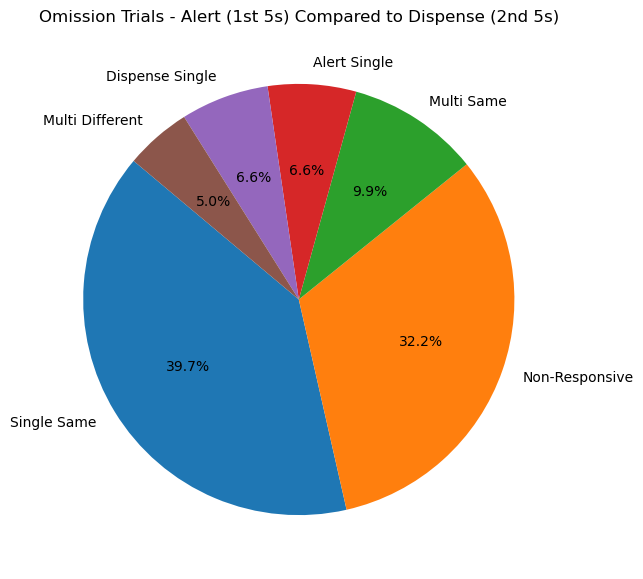

In [21]:
# This assumes merged_df1 is already defined and has a 'Result' column properly set up
omis_result_counts = omis_merged_df1['Result'].value_counts()

# Create the pie plot
plt.figure(figsize=(10, 7))
plt.pie(result_counts, labels=result_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Omission Trials - Alert (1st 5s) Compared to Dispense (2nd 5s)')

# Display the plot
plt.show()
# Optionally save the plot
# plt.savefig('Neuronal_Response_Distribution.png', bbox_inches='tight')

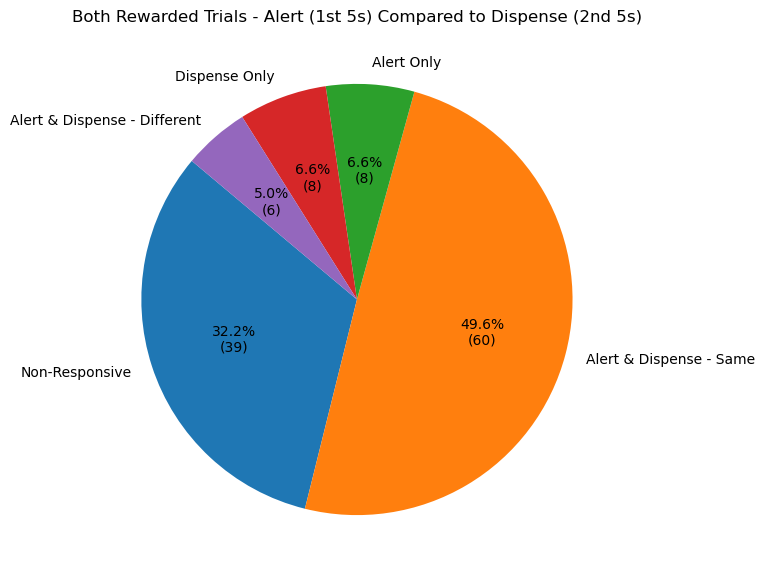

In [22]:
import matplotlib.pyplot as plt

Pieplot_labels = ('Non-Responsive', 'Alert & Dispense - Same', 'Alert Only', 'Dispense Only', 'Alert & Dispense - Different')
Pieplot_data = (39, 60, 8, 8, 6)

# Define a custom function to format the labels with both raw data and percentage
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.1f}%\n({v:d})'.format(p=pct, v=val)
    return my_autopct

# Create the pie plot
plt.figure(figsize=(10, 7))
plt.pie(Pieplot_data, labels=Pieplot_labels, autopct=make_autopct(Pieplot_data), startangle=140)
plt.title('Both Rewarded Trials - Alert (1st 5s) Compared to Dispense (2nd 5s)')

# Display the plot
# plt.show()
plt.savefig('both_reward_alert_dispense.png', bbox_inches='tight')

In [24]:
first5_win_df

,original unit id,Wilcoxon Stat,p value,event1 vs event2,Recording,Subject,Event
0,9,NaN,NaN,not significant,20230622_110832_standard_comp_to_both_rewarded...,1-1,5s win vs 10s baseline
1,24,NaN,NaN,not significant,20230622_110832_standard_comp_to_both_rewarded...,1-1,5s win vs 10s baseline
2,76,NaN,NaN,not significant,20230622_110832_standard_comp_to_both_rewarded...,1-1,5s win vs 10s baseline
3,10,NaN,NaN,not significant,20230622_110832_standard_comp_to_both_rewarded...,1-1,5s win vs 10s baseline
4,94,NaN,NaN,not significant,20230622_110832_standard_comp_to_both_rewarded...,1-1,5s win vs 10s baseline
...,...,...,...,...,...,...,...
116,39,4.0,0.715001,not significant,20230625_112913_standard_comp_to_both_rewarded...,1-4,5s win vs 10s baseline
117,17,2.0,0.273322,not significant,20230625_112913_standard_comp_to_both_rewarded...,1-4,5s win vs 10s baseline
118,15,4.0,0.715001,not significant,20230625_112913_standard_comp_to_both_rewarded...,1-4,5s win vs 10s baseline
119,27,4.0,0.715001,not significant,20230625_112913_standard_comp_to_both_rewarded...,1-4,5s win vs 10s baseline


In [25]:
merged_df1

,Recording,Subject,original unit id,first5_sig_increase_events,first5_sig_decrease_events,first5_insig_events,first5_sig_events,last5_sig_increase_events,last5_sig_decrease_events,last5_insig_events,last5_sig_events,first5_set,last5_set,Result
0,20230622_110832_standard_comp_to_both_rewarded...,1-1,9,,,"both_rewarded, win, lose",,,,"both_rewarded, win, lose",,{},{},Non-Responsive
1,20230622_110832_standard_comp_to_both_rewarded...,1-1,24,,,"both_rewarded, win, lose",,,,"both_rewarded, win, lose",,{},{},Non-Responsive
2,20230622_110832_standard_comp_to_both_rewarded...,1-1,76,,,"both_rewarded, win, lose",,,,"both_rewarded, win, lose",,{},{},Non-Responsive
3,20230622_110832_standard_comp_to_both_rewarded...,1-1,10,both_rewarded,,"win, lose",both_rewarded,both_rewarded,,"win, lose",both_rewarded,{both_rewarded},{both_rewarded},Alert & Dispense - Same
4,20230622_110832_standard_comp_to_both_rewarded...,1-1,94,both_rewarded,,"win, lose",both_rewarded,,,"both_rewarded, win, lose",,{both_rewarded},{},Alert Only
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,20230625_112913_standard_comp_to_both_rewarded...,1-4,39,,both_rewarded,"win, lose",both_rewarded,both_rewarded,,"win, lose",both_rewarded,{both_rewarded},{both_rewarded},Alert & Dispense - Same
117,20230625_112913_standard_comp_to_both_rewarded...,1-4,17,both_rewarded,,"win, lose",both_rewarded,both_rewarded,,"win, lose",both_rewarded,{both_rewarded},{both_rewarded},Alert & Dispense - Same
118,20230625_112913_standard_comp_to_both_rewarded...,1-4,15,,,"both_rewarded, win, lose",,,,"both_rewarded, win, lose",,{},{},Non-Responsive
119,20230625_112913_standard_comp_to_both_rewarded...,1-4,27,both_rewarded,,"win, lose",both_rewarded,both_rewarded,,"win, lose",both_rewarded,{both_rewarded},{both_rewarded},Alert & Dispense - Same


In [27]:
merged_df1['first5_set'].value_counts()

first5_set
{}                       47
{both_rewarded}          43
{win}                    14
{both_rewarded, win}      8
{both_rewarded, lose}     8
{lose}                    1
Name: count, dtype: int64

In [34]:
# Function to adjust the sets
def adjust_set(event_set):
    return 'Win' if 'win' in event_set else 'Non-Responsive'

# Create the new dataframe with selected columns and modified sets
merged_df2 = merged_df1[['Recording', 'Subject', 'original unit id', 'first5_set', 'last5_set']].copy()
merged_df2['first5_set'] = merged_df2['first5_set'].apply(adjust_set)
merged_df2['last5_set'] = merged_df2['last5_set'].apply(adjust_set)

# Display the new dataframe
merged_df2

,Recording,Subject,original unit id,first5_set,last5_set
0,20230622_110832_standard_comp_to_both_rewarded...,1-1,9,Non-Responsive,Non-Responsive
1,20230622_110832_standard_comp_to_both_rewarded...,1-1,24,Non-Responsive,Non-Responsive
2,20230622_110832_standard_comp_to_both_rewarded...,1-1,76,Non-Responsive,Non-Responsive
3,20230622_110832_standard_comp_to_both_rewarded...,1-1,10,Non-Responsive,Non-Responsive
4,20230622_110832_standard_comp_to_both_rewarded...,1-1,94,Non-Responsive,Non-Responsive
...,...,...,...,...,...
116,20230625_112913_standard_comp_to_both_rewarded...,1-4,39,Non-Responsive,Non-Responsive
117,20230625_112913_standard_comp_to_both_rewarded...,1-4,17,Non-Responsive,Non-Responsive
118,20230625_112913_standard_comp_to_both_rewarded...,1-4,15,Non-Responsive,Non-Responsive
119,20230625_112913_standard_comp_to_both_rewarded...,1-4,27,Non-Responsive,Non-Responsive


In [35]:
merged_df2['first5_set'].value_counts()

first5_set
Non-Responsive    99
Win               22
Name: count, dtype: int64

In [36]:
def event_overlap(df, event, newdf):
    def event_overlap_relabel(df, event, newdf):
        return event if event in event_set else set()

    newdf = []
    newdf = df[['Recording', 'Subject', 'original unit id', 'first5_set', 'last5_set']].copy()
    newdf['first5_set'] = newdf['first5_set'].apply(event_overlap_relabel)
    newdf['last5_set'] = newdf['last5_set'].apply(event_overlap_relabel)

    def determine_result(newdf):
        first_set = newdf['first5_set']
        last_set = newdf['last5_set']
    
        # Cases where both sets are empty
        if not first_set and not last_set:
            return 'Non-Responsive'
        
        # Cases where only one set is non-empty
        elif not first_set:
            return 'Dispense Only'
        elif not last_set:
            return 'Alert Only'
    
        elif first_set == last_set:
            return 'Alert & Dispense'
            
        # All other cases where one set has more than one event and the other has one or more
        return 'Wtf?'

    # Apply the function to the DataFrame
    newdf['Result'] = newdf.apply(determine_result, axis=1)

merged_df3 = event_overlap(merged_df1, 'win', 'merged_df3')

TypeError: event_overlap.<locals>.event_overlap_relabel() missing 2 required positional arguments: 'event' and 'newdf'

In [39]:
import pandas as pd

def event_overlap_relabel(event_set, event):
    """ Returns a set containing the event if it's present, otherwise an empty set. """
    return {event} if event in event_set else set()

def determine_result(row):
    """ Determines the result based on the contents of the event sets. """
    first_set = row['first5_set']
    last_set = row['last5_set']

    if not first_set and not last_set:
        return 'Non-Responsive'
    elif not first_set:
        return 'Dispense Only'
    elif not last_set:
        return 'Alert Only'
    elif first_set == last_set:
        return 'Alert & Dispense'
    return 'Wtf?'

def event_overlap(df, event):
    """ Processes the DataFrame to adjust sets based on the event and calculates results. """
    newdf = df[['Recording', 'Subject', 'original unit id', 'first5_set', 'last5_set']].copy()
    newdf['first5_set'] = newdf['first5_set'].apply(lambda x: event_overlap_relabel(x, event))
    newdf['last5_set'] = newdf['last5_set'].apply(lambda x: event_overlap_relabel(x, event))
    newdf['Result'] = newdf.apply(determine_result, axis=1)
    return newdf

# Assuming 'merged_df1' is your original DataFrame
both_rwd_win_df = event_overlap(merged_df1, 'win')

both_rwd_win_df

,Recording,Subject,original unit id,first5_set,last5_set,Result
0,20230622_110832_standard_comp_to_both_rewarded...,1-1,9,{},{},Non-Responsive
1,20230622_110832_standard_comp_to_both_rewarded...,1-1,24,{},{},Non-Responsive
2,20230622_110832_standard_comp_to_both_rewarded...,1-1,76,{},{},Non-Responsive
3,20230622_110832_standard_comp_to_both_rewarded...,1-1,10,{},{},Non-Responsive
4,20230622_110832_standard_comp_to_both_rewarded...,1-1,94,{},{},Non-Responsive
...,...,...,...,...,...,...
116,20230625_112913_standard_comp_to_both_rewarded...,1-4,39,{},{},Non-Responsive
117,20230625_112913_standard_comp_to_both_rewarded...,1-4,17,{},{},Non-Responsive
118,20230625_112913_standard_comp_to_both_rewarded...,1-4,15,{},{},Non-Responsive
119,20230625_112913_standard_comp_to_both_rewarded...,1-4,27,{},{},Non-Responsive


In [40]:
both_rwd_win_df['Result'].value_counts()

Result
Non-Responsive      98
Alert & Dispense    20
Alert Only           2
Dispense Only        1
Name: count, dtype: int64

In [41]:
both_rwd_lose_df = event_overlap(merged_df1, 'lose')
both_rwd_lose_df['Result'].value_counts()

Result
Non-Responsive      110
Alert & Dispense      7
Alert Only            2
Dispense Only         2
Name: count, dtype: int64

In [42]:
both_rwd_both_rwd_df = event_overlap(merged_df1, 'both_rewarded')
both_rwd_both_rwd_df['Result'].value_counts()

Result
Non-Responsive      55
Alert & Dispense    51
Alert Only           8
Dispense Only        7
Name: count, dtype: int64

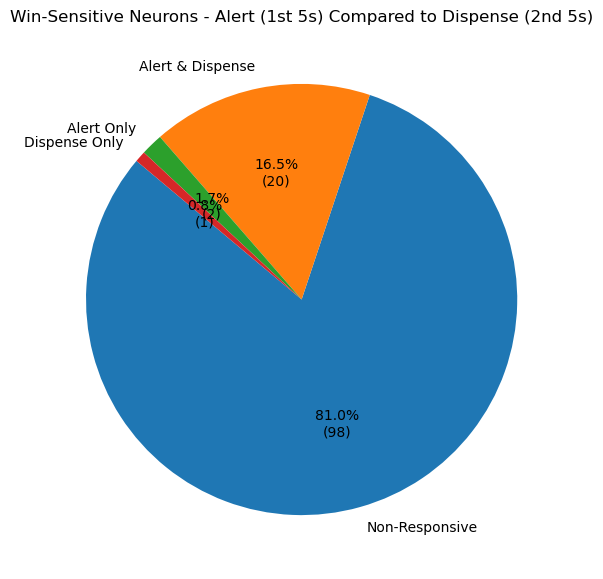

In [43]:
# This assumes merged_df1 is already defined and has a 'Result' column properly set up
br_win_counts = both_rwd_win_df['Result'].value_counts()

# Create the pie plot
plt.figure(figsize=(10, 7))
plt.pie(br_win_counts, labels=br_win_counts.index, autopct=make_autopct(br_win_counts), startangle=140)
plt.title('Win-Sensitive Neurons - Alert (1st 5s) Compared to Dispense (2nd 5s)')

# Display the plot
plt.show()
# plt.savefig('Neuronal_Response_Distribution.png', bbox_inches='tight')

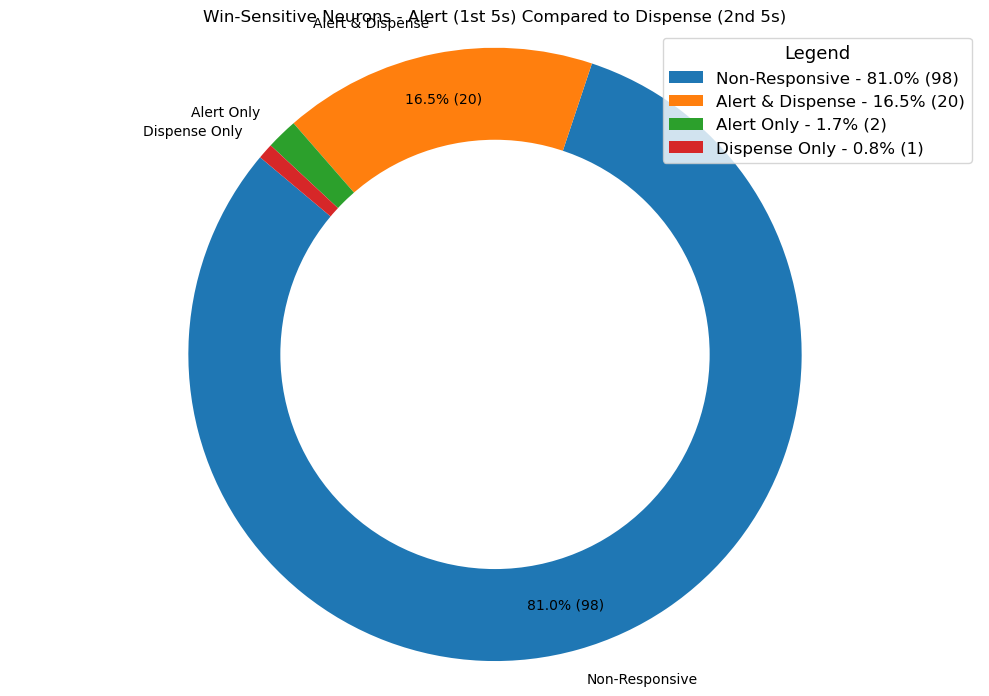

In [44]:
import matplotlib.pyplot as plt

# Define a custom function to format the labels with both raw data and percentage
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.1f}% ({v:d})'.format(p=pct, v=val) if pct >= 3 else ''
    return my_autopct

# This assumes merged_df1 is already defined and has a 'Result' column properly set up
br_win_counts = both_rwd_win_df['Result'].value_counts()

# Create the pie plot
plt.figure(figsize=(10, 7))
wedges, texts, autotexts = plt.pie(br_win_counts, labels=br_win_counts.index, autopct=make_autopct(br_win_counts), startangle=140, pctdistance=0.85)

# Draw a circle at the center of pie to make it a donut
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Equal aspect ratio ensures that pie is drawn as a circle
plt.axis('equal')  

# Enhance labels if smaller than 3%
for autotext in autotexts:
    if autotext.get_text() == '':
        autotext.set_color('black')
        autotext.set_horizontalalignment('center')
        autotext.set_size('x-small')

# Include a legend that provides the count and percentage
plt.legend(
    loc='upper right',
    labels=['{0} - {1:.1f}% ({2:d})'.format(i, 100.*count/br_win_counts.sum(), count) for i, count in br_win_counts.items()],
    title="Legend",
    title_fontsize='13',
    fontsize='12'
)

plt.title('Win-Sensitive Neurons - Alert (1st 5s) Compared to Dispense (2nd 5s)')
plt.tight_layout()  # Adjust the layout to make room for the legend

# Display the plot
plt.show()
# plt.savefig('Neuronal_Response_Distribution.png', bbox_inches='tight')

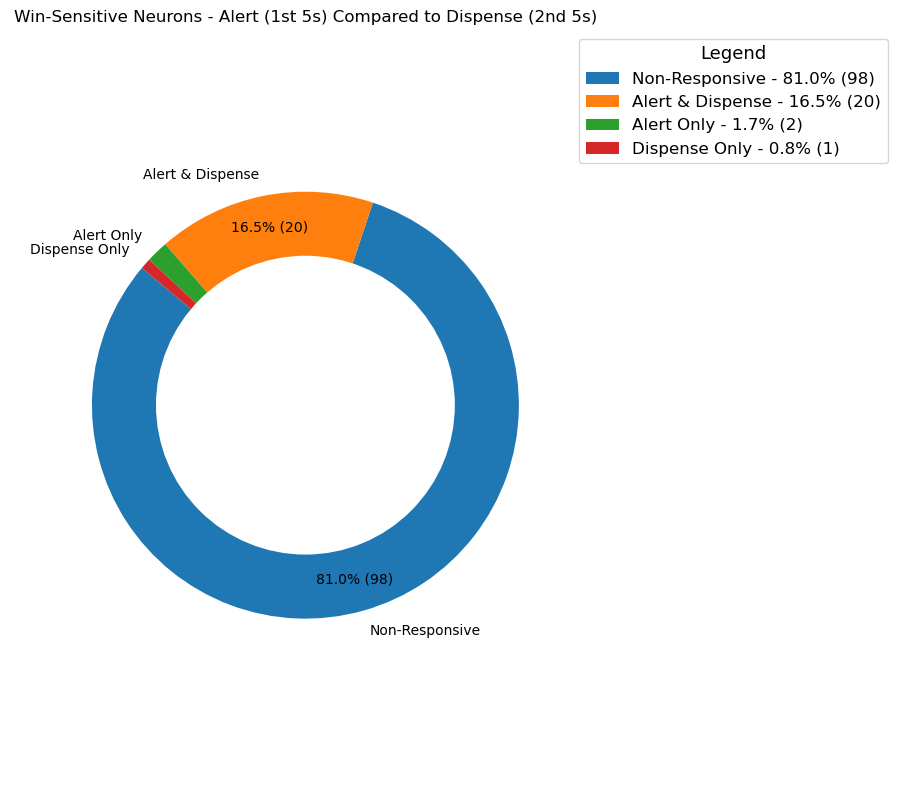

In [48]:
import matplotlib.pyplot as plt

# Define a custom function to format the labels with both raw data and percentage
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.1f}% ({v:d})'.format(p=pct, v=val) if pct >= 3 else ''
    return my_autopct

# This assumes merged_df1 is already defined and has a 'Result' column properly set up
br_win_counts = both_rwd_win_df['Result'].value_counts()

# Create the pie plot
plt.figure(figsize=(10, 8))  # Increase the figure size for better spacing
wedges, texts, autotexts = plt.pie(br_win_counts, labels=br_win_counts.index, autopct=make_autopct(br_win_counts), startangle=140, pctdistance=0.85)

# Draw a circle at the center of pie to make it a donut
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Equal aspect ratio ensures that pie is drawn as a circle
plt.axis('equal')  

# Adjust the autopct placement
for autotext in autotexts:
    if autotext.get_text() == '':
        autotext.set_color('black')
        autotext.set_horizontalalignment('center')
        autotext.set_size('x-small')

# Adjust the title and legend
plt.title('Win-Sensitive Neurons - Alert (1st 5s) Compared to Dispense (2nd 5s)')  # Increase pad to push the title up

plt.legend(
    loc='upper right',
    bbox_to_anchor=(1, 0, 0.5, 1),  # Adjust the anchor of the legend
    labels=['{0} - {1:.1f}% ({2:d})'.format(i, 100.*count/br_win_counts.sum(), count) for i, count in br_win_counts.items()],
    title="Legend",
    title_fontsize='13',
    fontsize='12'
)

plt.tight_layout()  # Adjust the layout to make room for the legend and title

# Display the plot
plt.show()
# plt.savefig('Neuronal_Response_Distribution.png', bbox_inches='tight')

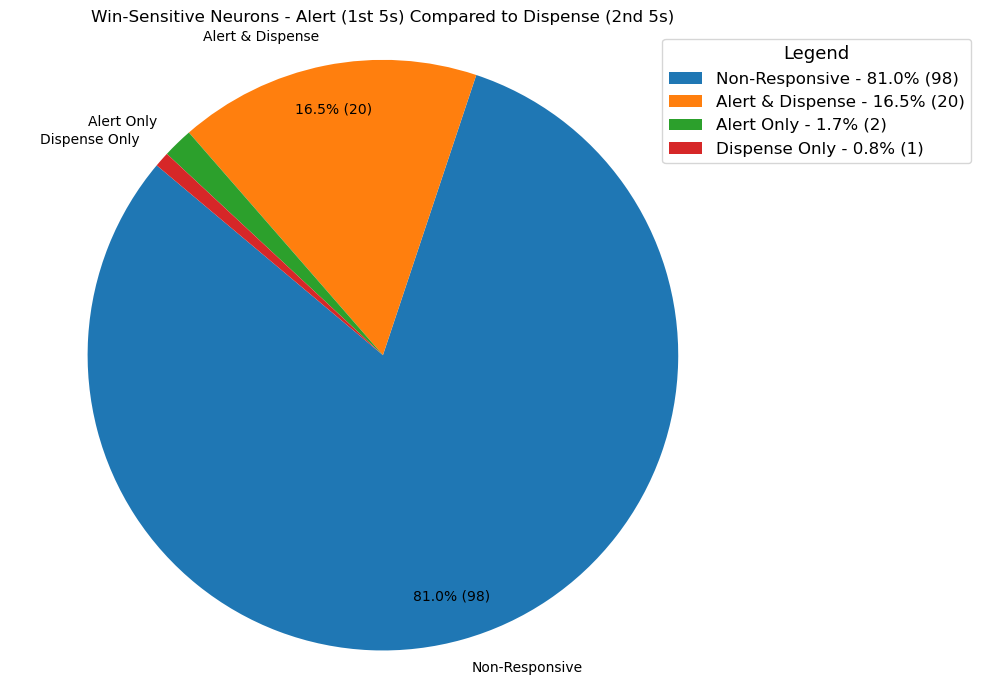

In [58]:
import matplotlib.pyplot as plt

# Define a custom function to format the labels with both raw data and percentage
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.1f}% ({v:d})'.format(p=pct, v=val) if pct >= 3 else ''
    return my_autopct

# This assumes merged_df1 is already defined and has a 'Result' column properly set up
br_win_counts = both_rwd_win_df['Result'].value_counts()

# Create the pie plot
plt.figure(figsize=(10, 7))
wedges, texts, autotexts = plt.pie(br_win_counts, labels=br_win_counts.index, autopct=make_autopct(br_win_counts), startangle=140, pctdistance=0.85)

# Draw a circle at the center of pie to make it a donut
# centre_circle = plt.Circle((0,0),0.70,fc='white')
# fig = plt.gcf()
# fig.gca().add_artist(centre_circle)

# Equal aspect ratio ensures that pie is drawn as a circle
plt.axis('equal')  

# Enhance labels if smaller than 3%
for autotext in autotexts:
    if autotext.get_text() == '':
        autotext.set_color('black')
        autotext.set_horizontalalignment('center')
        autotext.set_size('x-small')

# Include a legend that provides the count and percentage
plt.legend(
    loc='upper right',
    bbox_to_anchor=(.8, 0, 0.5, 1),
    labels=['{0} - {1:.1f}% ({2:d})'.format(i, 100.*count/br_win_counts.sum(), count) for i, count in br_win_counts.items()],
    title="Legend",
    title_fontsize='13',
    fontsize='12'
)

plt.title('Win-Sensitive Neurons - Alert (1st 5s) Compared to Dispense (2nd 5s)')
plt.tight_layout()  # Adjust the layout to make room for the legend

# Display the plot
# plt.show()
plt.savefig('both_reward_win_alert_dispense.png', bbox_inches='tight')

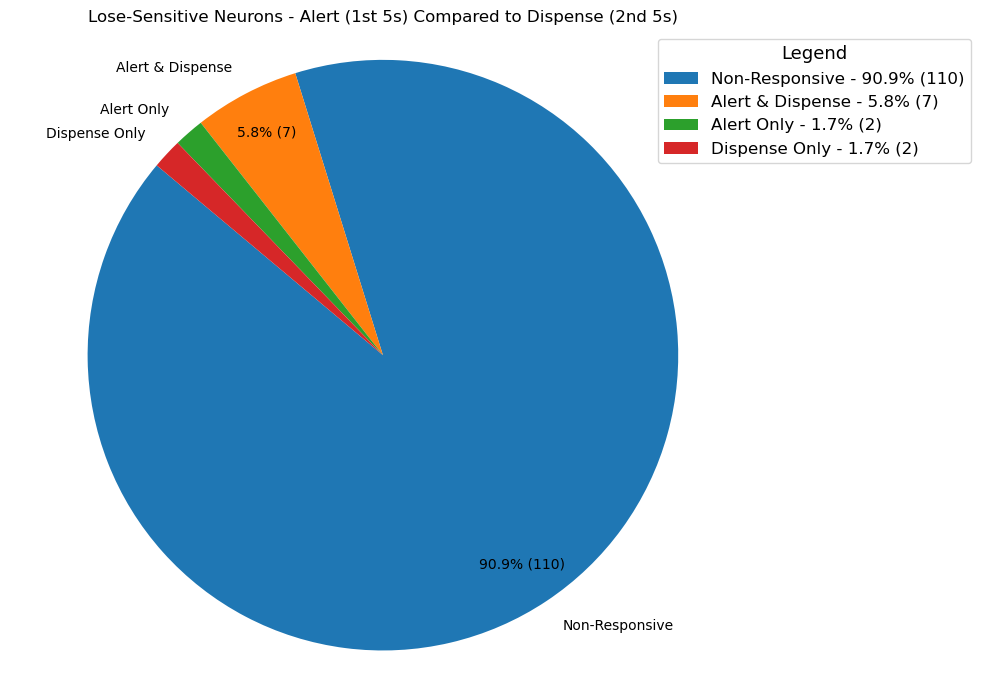

In [59]:
# This assumes merged_df1 is already defined and has a 'Result' column properly set up
br_lose_counts = both_rwd_lose_df['Result'].value_counts()

# Create the pie plot
plt.figure(figsize=(10, 7))
wedges, texts, autotexts = plt.pie(br_lose_counts, labels=br_lose_counts.index, autopct=make_autopct(br_lose_counts), startangle=140, pctdistance=0.85)

# Draw a circle at the center of pie to make it a donut
# centre_circle = plt.Circle((0,0),0.70,fc='white')
# fig = plt.gcf()
# fig.gca().add_artist(centre_circle)

# Equal aspect ratio ensures that pie is drawn as a circle
plt.axis('equal')  

# Enhance labels if smaller than 3%
for autotext in autotexts:
    if autotext.get_text() == '':
        autotext.set_color('black')
        autotext.set_horizontalalignment('center')
        autotext.set_size('x-small')

# Include a legend that provides the count and percentage
plt.legend(
    loc='upper right',
    bbox_to_anchor=(.8, 0, 0.5, 1),
    labels=['{0} - {1:.1f}% ({2:d})'.format(i, 100.*count/br_lose_counts.sum(), count) for i, count in br_lose_counts.items()],
    title="Legend",
    title_fontsize='13',
    fontsize='12'
)

plt.title('Lose-Sensitive Neurons - Alert (1st 5s) Compared to Dispense (2nd 5s)')
plt.tight_layout()  # Adjust the layout to make room for the legend

# Display the plot
# plt.show()
plt.savefig('both_reward_lose_alert_dispense.png', bbox_inches='tight')

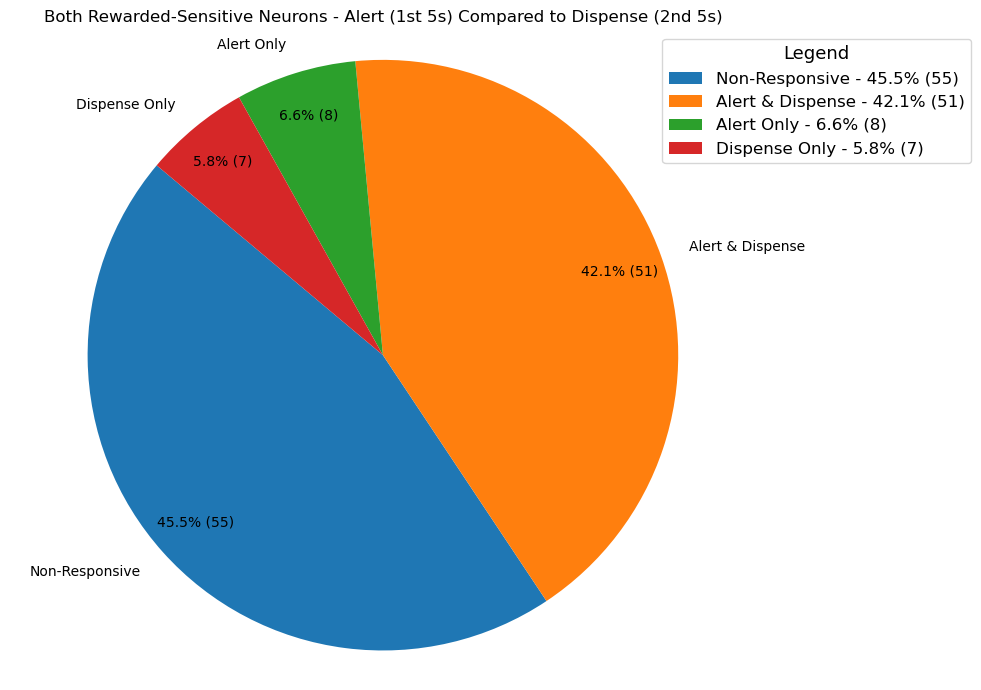

In [60]:
# This assumes merged_df1 is already defined and has a 'Result' column properly set up
br_br_counts = both_rwd_both_rwd_df['Result'].value_counts()

# Create the pie plot
plt.figure(figsize=(10, 7))
wedges, texts, autotexts = plt.pie(br_br_counts, labels=br_br_counts.index, autopct=make_autopct(br_br_counts), startangle=140, pctdistance=0.85)

# Draw a circle at the center of pie to make it a donut
# centre_circle = plt.Circle((0,0),0.70,fc='white')
# fig = plt.gcf()
# fig.gca().add_artist(centre_circle)

# Equal aspect ratio ensures that pie is drawn as a circle
plt.axis('equal')  

# Enhance labels if smaller than 3%
for autotext in autotexts:
    if autotext.get_text() == '':
        autotext.set_color('black')
        autotext.set_horizontalalignment('center')
        autotext.set_size('x-small')

# Include a legend that provides the count and percentage
plt.legend(
    loc='upper right',
    bbox_to_anchor=(.8, 0, 0.5, 1),
    labels=['{0} - {1:.1f}% ({2:d})'.format(i, 100.*count/br_br_counts.sum(), count) for i, count in br_br_counts.items()],
    title="Legend",
    title_fontsize='13',
    fontsize='12'
)

plt.title('Both Rewarded-Sensitive Neurons - Alert (1st 5s) Compared to Dispense (2nd 5s)')
plt.tight_layout()  # Adjust the layout to make room for the legend

# Display the plot
# plt.show()
plt.savefig('both_reward_both_reward_alert_dispense.png', bbox_inches='tight')